<img src="data/drill_ship.png" style="width:300px; float:left">
<h1 style="text-align: center; color:teal">Data Science and Machine Learning for Planet Earth - Assessment</h1>

<h3 style="text-align: center; color:darkgray">Taken by MSc students on the ACSE, EDSML and GEMS courses</h3>

<h2 style="text-align: center; color:darkred">09:00 – 17:00 BST, Friday 17th of November 2023</h2>

<h2 style="text-align: center; color:red">REMINDER: THIS IS AN INDIVIDUAL ASSESSMENT</h2>

# 🐟 Read the `README.md` file for important information:

We strongly recommend that you read the `README.md` file, and even keep it open on GitHub for referencing during the assessement. It contains more detail on:

- <h3 style="color:teal">Description of the features of your data, and what they mean</h3>
- <h3 style="color:brown">A recommended workflow for this assessment</h3>
- <h3 style="color:teal">A reminder about what constitutes plagiarism</h3>
- <h3 style="color:brown">Details about the assessment criteria</h3>
- <h3 style="color:teal">Submitting your assessment</h3>
- <h3 style="color:brown">Referrencing your sources</h3>

To keep this notebook tidy and small, all of the above are available in the `README.md` file in this repo. 

In [1]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer

# for model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# for metrics
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# for fine-tune
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats

# for PCA
from sklearn.decomposition import PCA

# 🌊 Predicting Lithologies for the Ocean Drilling Program

In this assessment, you are the **boss of your own AI consluting company**: ***<span style="color:teal">MSC-AI Consulting</span>***. Your client is the **Integrated Ocean Drilling Program** (IODP), a reputable research institution with the mission of drilling the seafloor in order to understand the dynamic of the Earth and its past climates. You know that IODP has approached other, competing AI consulting companies: so don't let them see your answer, and try to do better than them to convince the client to give you the best score!

IODP routinely uses two different types of data:

1. **Cores**: A core is a piece of rock recovered from the seafloor. This allows geologist to perform analysis on the material, and to identify exactly what type of rock is present. Cores are however difficult to recover, and expensive. You can <a href="https://www.ga.gov.au/scientific-topics/marine/survey-techniques/sedimentary-coring-drilling">learn more about cores here if you want</a>.
2. **Downhole (wireline) logs**: IODP can also use downhole or wireline logs, i.e. data from  instruments that are lowered in a drill hole by research geologists. Drill holes can be very deep, down to several kilometers below the water-sediment interface (the unit used is `Depth_WMSF`, also known as meters below seafloor - larger numbers means deeper in the well). Downhole logs record properties of the rocks they measure, including natural gamma radiation (total gamma ray `HCGR`, potassium `HFK`, thorium `HTHO`, uranium `HURA`, shallow and deep penetration resistivity (`IDPH` and `IMPH`) and neutron porosity (`SFLU`). The goal is to use these properties measured continuously to estimate the **lithology** (i.e. type of rock) present. More details are provided <a href="https://en.wikipedia.org/wiki/Well_logging">on this website if you are interested</a>.

IODP has been experimenting recently with a brand new type of downhold log called <code>munsel_color</code>. They reckon that this new log type alongside the others could help in the identification of the lithology from wireline log data. They are very excited to test this, and have contacted you to help them - so you see this type of log for the first time.

## ⛴️ Your task

You are given drilling and logging data (`data/lithology.csv`) that can be used for training and testing, and that contains data from a single well (a drilling location) from 0 to 450 MWSF. In the context of the Integrated Ocean Drilling Program (IODP), the acronym **WMSF** stands for **Water-Depth Meters Below Seafloor**. This unit of measurement is commonly used in ocean drilling and marine geology to specify the depth below the seafloor at which samples are taken or observations are made. 

You are also being given a second file file (`data/new_samples.csv`) that contains logging data **in the same well** but from 450 WMSF down to 700 MWSF (so deeper than your training data). There is no core data in this interval, only logging data. This means that the `lithology` is not known, and **your goal is to use this wireline log data to predict lithology**. 

The following diagrams illustrates this situation:

<img src="data/well.jpg" style="width:600px;">

IODP wants you to train the best algorithm to classify lithology based on the log data provided. The also give you some strict guidance about what they want:

1. 🪸 You can prepare your data any way you want, and select any features you want. But as mentioned previously, IODP is very keen on using their new logging tool called `munsell_color` for your predictions. They stipulate that you need to use this feature in your data pipeline - how you use it is up to you.
<br><br>
2. 🪸 To predict `lithology`, you can use **any parametric model** from sklearn that you prefer. This includes for instance `LogisticRegression`, `SVC(kernel="linear")`, and many others. If you don't know whether your algorithm is parametric, you can try to call the `.coef_` method on it after you `fit` it. If you get an error, it is not parametric and using this model would disqualify you (for instance, `SVC()`, `RandomForest`, `KNeighborsClassifier` are not parametric). You are also told that using `ensemble methods` is not allowed. And you are strongly discouraged from using `MLPClassifier` (too long to train, and too many coefficients - see criteria 2 below).
<br><br>
3. 🪸 You need to put your entire workflow within a `pipeline` object. This pipeline can be of arbitrary complexity, but it needs to ***1.*** be able to take raw data and produce a predictions of labels directly, and ***2.*** the last position of your pipeline should be your parametric estimator (so if IODP does something like `pipeline[-1]` in their automatic testing they will obtain your estimator object).
<br><br>
4. 🪸 IODP will assess the performance of your algorithm in two ways. First, they will use the `F1 macro averaging` score on the label of your **unseen data** (i.e. the data in `data/new_samples.csv`), and subtract the `F1 macro averaging` score of your **test set** (which you can choose as you see fit). The smaller the difference between your test set score and the unseen data score, the better. This implies that they will want to have access to your test and train sets (see **Part C - Writing a class** for details).
<br><br>
5. 🪸 IODP also prefers a balance between high F1 macro score, but simpler models with **as few model coefficients (i.e. model weights) as possible** (as a reminder, the number of weights is exactly proportional to the number of features seen by the classifier). This is why, as a second assessment of your model performance, IODP will look at the ratio of your `F1 macro` score on the predicted **unseen data** divided by the **number of coefficients** in your model (i.e. `model.coef_.shape[1]`), this ratio then multiplied by 100 (higher=better). Hence, you should aim for as few weights as possible (i.e. coefficients) in your model whilst maintaining a decent performance. And as a reminder of point 1. above, you need to include the `munsell_color` feature one way or another in your classifier.
<br><br>
6. 🪸 For fairness, IODP wants you to set `random_state=42` for any algorithm that requires a random state. Failure to do so might result in a lower score.

# Run the cell below first

This will help automatically reload your class when you make changes to it in **Part C**.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# set config
from sklearn import set_config

set_config(display='diagram')
set_config(transform_output = "pandas")

# 🐳  PART A: Exploratory Data Analysis (EDA) [30 marks]

In this first task, the client wants you to use this notebook to do some <b>Exploratory Data Analysis</b>. <br>
Make sure to keep the notebook clean, and running from top to bottom. Use markdown cells to explain what you are doing, why, and what your finding and conclusions are. Your goal is the understand your data and how you can best model it.

In [4]:
import pandas as pd
# Load the data:

df = pd.read_csv('data/log_data.csv') # This is your EDA (Part A) and training data (Parts B and C)

new_samples = pd.read_csv('data/new_data.csv') # This is the file you need to predict in parts B and C

## Split data set

In [5]:
# Create as many cell as you need - keep your notebook clean
# see how many duplicates there are
df.duplicated().sum()

551

In [6]:
# drop duplicates
df.drop_duplicates(inplace=True)

# check duplicates
df.duplicated().sum()

0

In [7]:
# split X and y
y = df["lithology"]
X = df.drop(columns="lithology")

# split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 , random_state=42)

## EDA

In [8]:
# inspect missing values
X_train.isnull().sum()

DEPTH_WMSF      0
HCGR            0
HFK             0
HTHO            0
HURA            0
IDPH            0
IMPH            0
SFLU            0
munsel_color    0
dtype: int64

**Observation**: There is no missing values detected.

In [9]:
# inspect the type of X_train
X_train.dtypes

DEPTH_WMSF      float64
HCGR            float64
HFK             float64
HTHO            float64
HURA            float64
IDPH            float64
IMPH            float64
SFLU            float64
munsel_color     object
dtype: object

**Observation**: 'munsel_color' is categorical, encoder is needed.

In [10]:
# Select numerical and categorical columns
num_data = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_data = X_train.select_dtypes(include = 'object').columns.tolist()

In [11]:
# inspect the distribution of categorical fearure
for item in cat_data:
    print(item)
    print(X_train[item].value_counts())
    print("----------------------------")

munsel_color
10B 8 12       2795
5P 3 6         1154
2.5G 1 8       1070
10PB 0.2 18     791
10R 1 12        553
10P 5 30         53
5R 4 10          52
5BG 0.4 2        47
7.5P 2 16        47
7.5YR 9 20       46
7.5PB 4 34       45
5PB 5 18         44
5GY 6 16         44
5PB 3 32         44
7.5G 1 2         44
2.5P 8 2         44
2.5YR 8 10       43
10RP 5 22        43
7.5P 0.8 16      41
5Y 6 16          41
2.5R 6 22        41
5PB 1 14         40
10PB 1 42        39
10GY 6 18        39
2.5BG 3 24       39
10Y 2 2          39
5YR 5 14         38
10R 2 16         38
5G 7 34          37
2.5BG 5 16       37
10P 5 14         37
2.5G 7 2         36
10PB 2 42        36
2.5R 8 6         35
5P 7 20          33
10G 4 18         32
10BG 6 12        32
10B 2 6          30
2.5P 0.4 22      28
10GY 4 4         28
Name: munsel_color, dtype: int64
----------------------------


**Observation**: Feature 'munsel_color' looks has no inter-correlations so need to be one-hot-encoded.

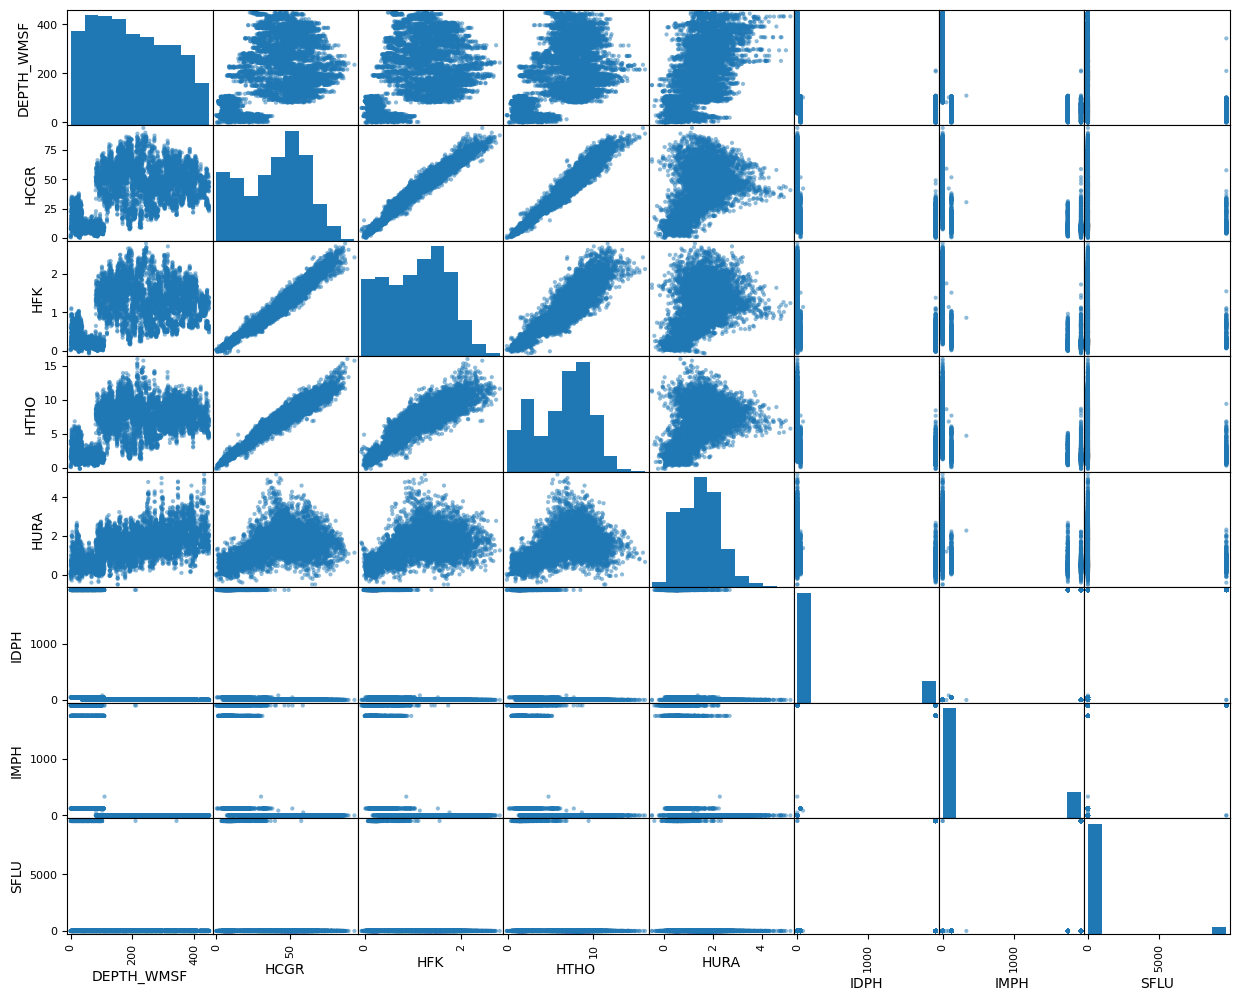

In [12]:
pd.plotting.scatter_matrix(X_train[num_data], figsize=(15,12));

**Observation** It is obvious that some features are correlated to others, it will be more clear if use heatmap to illustrate it.

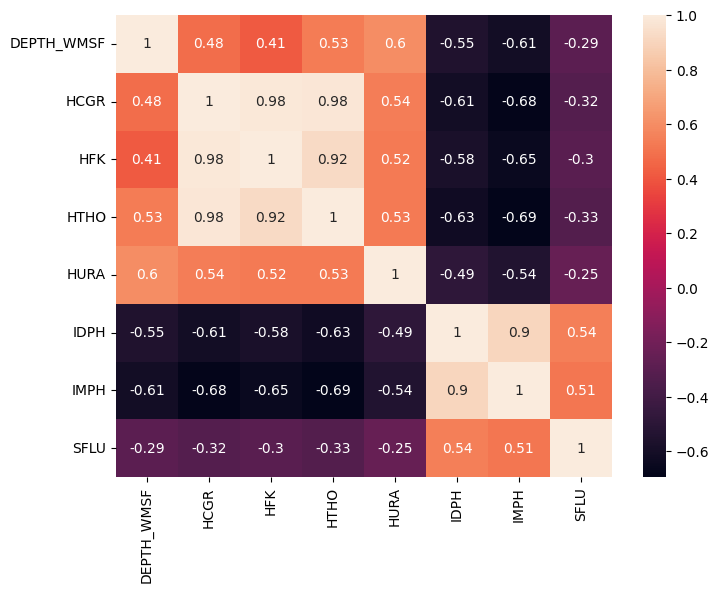

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
corr = X_train[num_data].corr()
sns.heatmap(data=corr, annot=corr, ax=ax);

**Observation** It is clear that 'HCGR' and 'HFK', 'HCGR' and 'HTHO', 'HFK' and 'HTHO', 'IMPH' and 'IDPH' have very high co-linearities (>0.9). High correlations mean there are redundant information, so some features need to be droped.

In [14]:
# drop redundant features
num_data.remove('HFK')
num_data.remove('HTHO')
num_data.remove('IMPH')
num_data

['DEPTH_WMSF', 'HCGR', 'HURA', 'IDPH', 'SFLU']

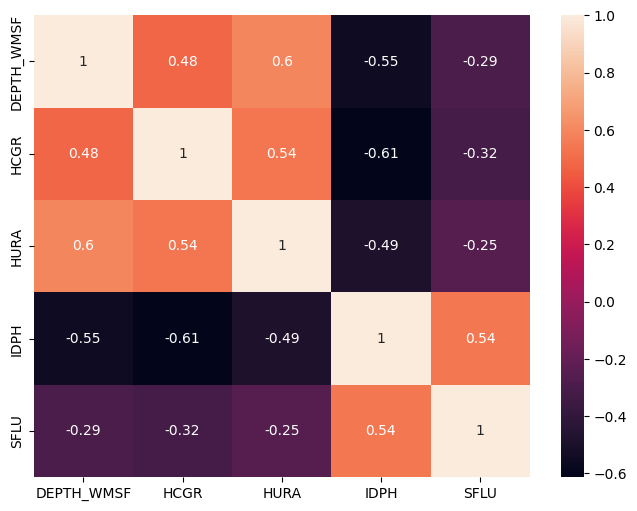

In [15]:
# check if there is high correlations
fig, ax = plt.subplots(1,1,figsize=(8,6))
corr = X_train[num_data].corr()
sns.heatmap(data=corr, annot=corr, ax=ax);

**Observation** After dropping redundant features, there are no more very high correlations (>0.9), but there are still linear correaltions, so it is better to use PCA.

In [16]:
# see if there are anomalies
X_train[num_data].describe()

,DEPTH_WMSF,HCGR,HURA,IDPH,SFLU
count,7755.000000,7755.000000,7755.000000,7755.000000,7755.000000
mean,199.429746,39.633128,1.467552,327.528230,544.857337
std,121.724927,20.945681,0.810021,723.865242,2231.938446
min,0.073600,0.086100,-0.510500,0.339900,0.091500
25%,94.787200,21.555350,0.813850,1.199300,0.628350
50%,186.916000,43.208400,1.463200,1.359200,0.751600
75%,298.689200,55.672900,1.996800,2.560100,1.093550
max,449.058400,93.633400,5.187800,1950.000000,9700.000000


**Observation** There are negative value in 'HURA' which should be treated as noise, so they should be droped.

In [17]:
# drop noises
neg_index = X_train.HURA[X_train.HURA < 0].index
X_train = X_train.drop(neg_index)
y_train = y_train.drop(neg_index)
X_train[num_data].describe()

,DEPTH_WMSF,HCGR,HURA,IDPH,SFLU
count,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000
mean,200.382882,39.764853,1.479430,319.564199,542.588967
std,121.569123,20.881861,0.801054,716.627378,2227.551189
min,0.073600,0.086100,0.002200,0.339900,0.091500
25%,95.643800,21.915200,0.830400,1.198525,0.629425
50%,188.903800,43.299600,1.470400,1.356800,0.753350
75%,299.532600,55.699075,2.000175,2.560100,1.093800
max,449.058400,93.633400,5.187800,1950.000000,9700.000000


**Observation** Now all values are within a reasonable range.

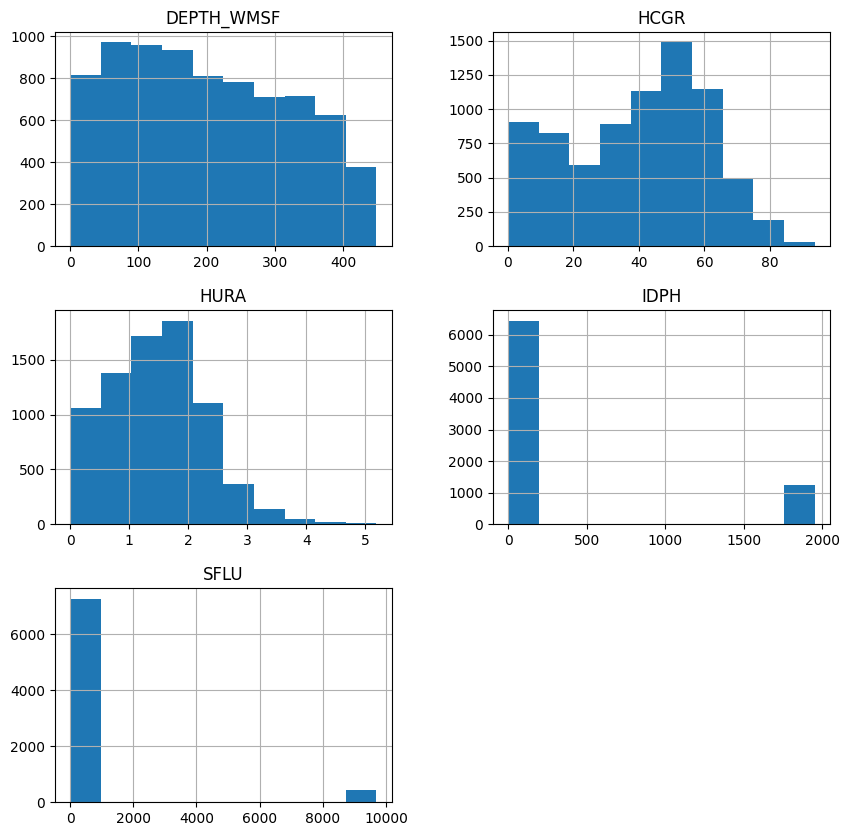

In [18]:
X_train[num_data].hist(figsize=(10,10));

**Observation**: The distribution of each feature is not uniform, so scaler is needed. It is clear that 'IDPH' and 'SFLU' does not follow Gaussian distribution.

array([[<AxesSubplot: title={'center': 'IDPH'}>]], dtype=object)

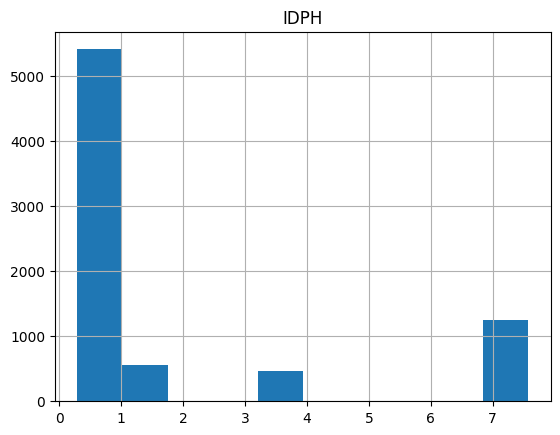

In [19]:
np.log(X_train[["IDPH"]] + 1).hist()

**Observation**: Log transformation seems not to be very useful.

Right-hand-side cluster has number of 1246


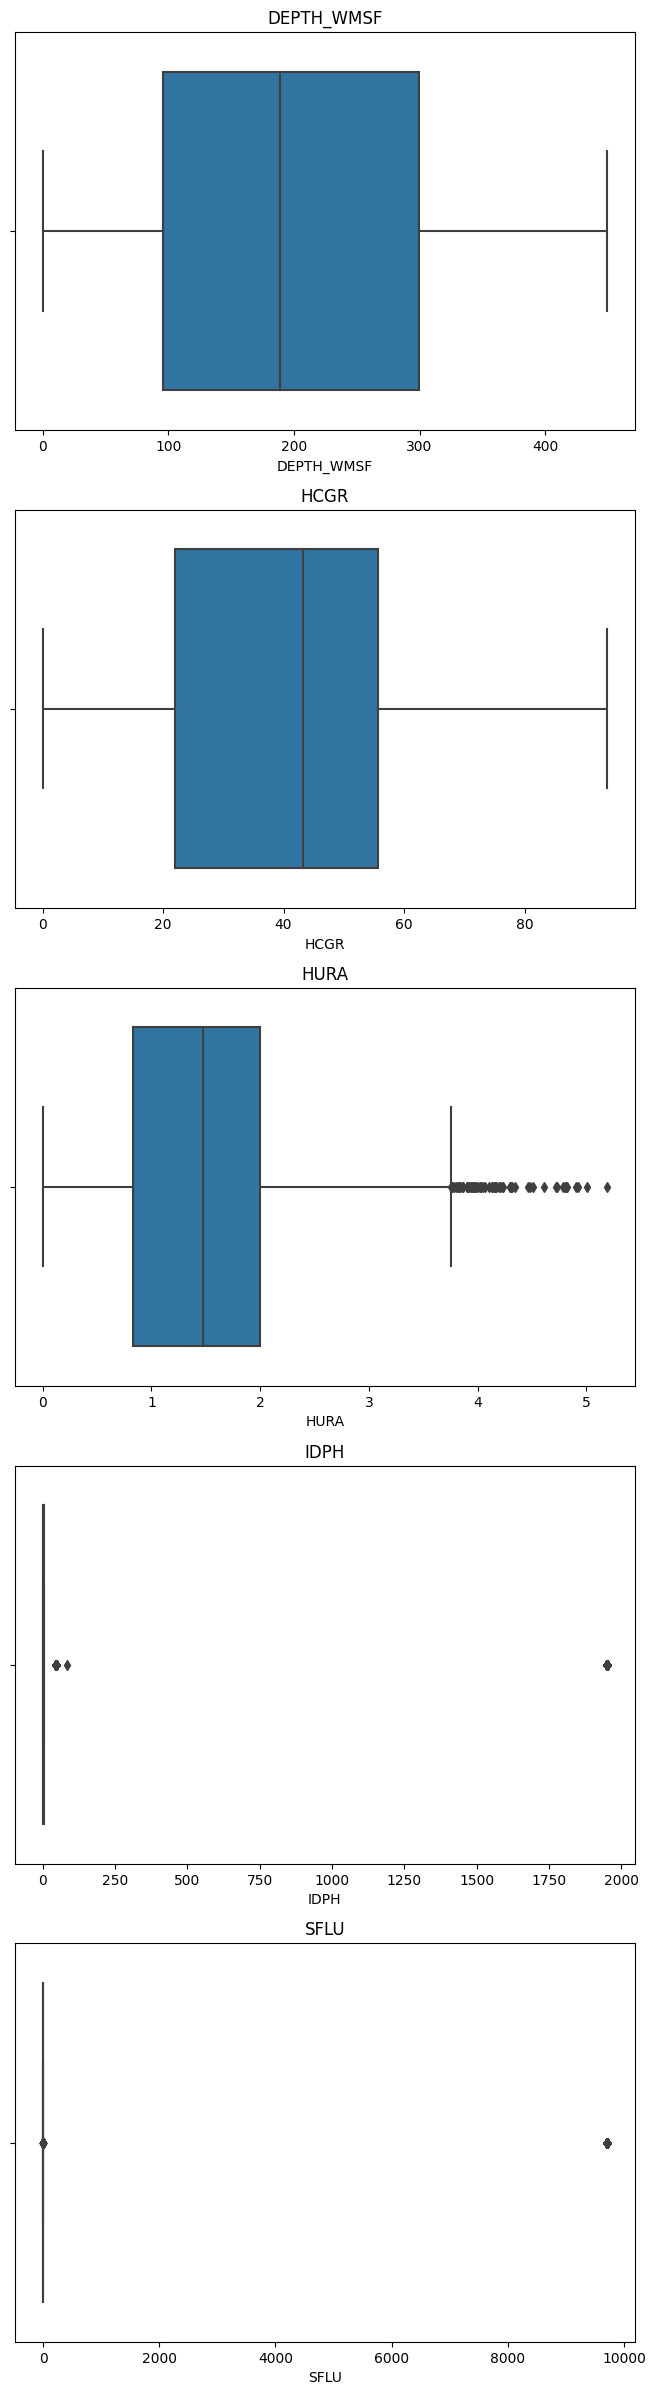

In [20]:
# detect outliers
print('Right-hand-side cluster has number of {}'.format(X_train.IDPH[X_train.IDPH > 1500].count()))
fig, axes = plt.subplots(len(num_data), 1, figsize=(8, 30))

for column_name, ax in zip(num_data, axes):
    sns.boxplot(data=X_train, x=column_name, ax=ax)  # Assuming `num_data` are column names and the data is vertical
    ax.set_title(column_name)

**Observation**: Although boxplot of 'IDPH' and 'SFLU' shows there are 'outliers', other features do not show the same trend. Meanwhile, the number of data for 'IDPH' > 1500 counts for a quite large portion of all data. So it is ok to assume there are few outliers.

In [21]:
# Check for the distribution of our labels
y_train.value_counts()

Mud                          3414
Marl                         1428
Interbedded clay and mud     1278
Sandy Mud                     961
Interbedded sand and mud      617
Name: lithology, dtype: int64

**Observation**: The dataset seems to have a fair balance of distributions.

In [22]:
# encode
l_encoder = LabelEncoder().fit(y_train)
y_train_encoded = l_encoder.transform(y_train)

y_test_cat = y_test.copy()
y_test_encoded = l_encoder.transform(y_test)

# 🐠 PART B: Finding the best model [30 marks]

Once you understand your data, you can start to find the best model. Remember that IODP has a few criteria for you:
1. You must at least use the `munsell_color` feature in your model
2. You must write the entire model as a `pipeline` that can process raw data and return a prediction. Your estimator must be a `parametric model`, i.e. `model.coef_` must return the coefficients of the model.
3. Your model will be evaluated against performance on the unseen data. This will include checking how close your predicted `F1 macro` of your test set is to the `F1 macro` calculated by your model on the unseen data (IODP has secret labels for that).
4. Your model will also be evaluated for simplicity versus performance, i.e. the ratio of `F1 macro` on the unseen data against the `number of coefficients` (not their values) of your model.

Once you have defined and trained your best model, please run the cell below the next empty cell. This cell assumes that 1. your trained best model is called `best_model`, your `X_test` and your `y_test_cat` are named exactly like this (and `y_train_cat` represents the `y_test` transformed into categorical value. Running this cell will save values that will be used for automatic testing of your results, so this is important. If your variables have different names, you can change this code.

In [23]:
# Create as many cells as you need - keep your notebook clean
# Impute then Scale for numerical variables: 
num_transformer = Pipeline([
    ('num_imputer', SimpleImputer()),
    ('num_scaler', StandardScaler())])

# Encode categorical variables
cat_transformer = Pipeline([
    ('cat_imputer',SimpleImputer(strategy = 'most_frequent')),
    ('cat_encoder',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
     ])

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, num_data),
    ('cat_transformer', cat_transformer, cat_data)
])

# fit the preprocessor
preprocessor.fit(X_train)

# transform
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_train_prep

,num_transformer__DEPTH_WMSF,num_transformer__HCGR,num_transformer__HURA,num_transformer__IDPH,num_transformer__SFLU,cat_transformer__munsel_color_10B 2 6,cat_transformer__munsel_color_10B 8 12,cat_transformer__munsel_color_10BG 6 12,cat_transformer__munsel_color_10G 4 18,cat_transformer__munsel_color_10GY 4 4,...,cat_transformer__munsel_color_5PB 3 32,cat_transformer__munsel_color_5PB 5 18,cat_transformer__munsel_color_5R 4 10,cat_transformer__munsel_color_5Y 6 16,cat_transformer__munsel_color_5YR 5 14,cat_transformer__munsel_color_7.5G 1 2,cat_transformer__munsel_color_7.5P 0.8 16,cat_transformer__munsel_color_7.5P 2 16,cat_transformer__munsel_color_7.5PB 4 34,cat_transformer__munsel_color_7.5YR 9 20
10379,1.393444,1.038684,0.857015,-0.444305,-0.243315,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,-0.453241,0.778355,0.302958,-0.444121,-0.243279,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8547,0.740472,0.150401,1.018063,-0.444151,-0.243118,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5131,-0.309066,1.127944,-0.830498,-0.444301,-0.243299,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6433,0.063470,0.585290,0.031174,-0.444325,-0.243266,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024,-0.058009,1.532436,-0.502783,-0.443478,-0.243123,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5452,-0.214720,-0.454240,-0.032622,-0.441966,-0.242830,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,-0.162066,2.166267,-0.018015,-0.443837,-0.243261,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,-1.374511,-0.521001,-0.076691,2.275299,-0.243556,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


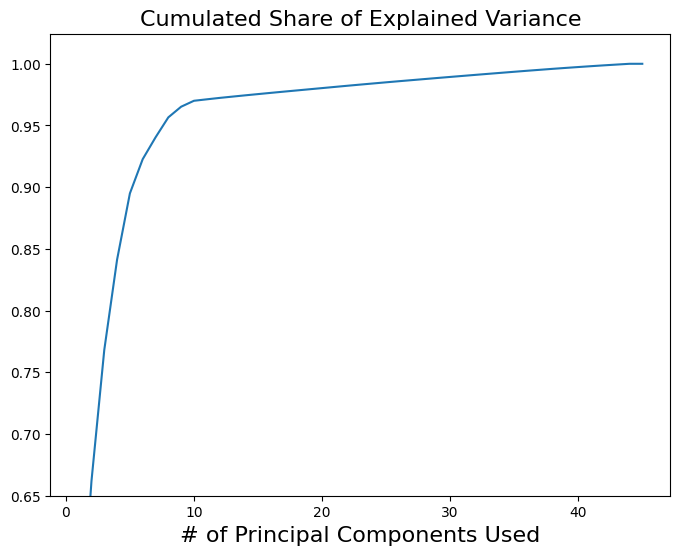

In [24]:
# Access our PCs
pca = PCA().fit(X_train_prep)
explained_variance_ratio = pca.explained_variance_ratio_

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot the cumulative sum of explained variance ratio
ax.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio))

# Set the limits for y-axis
ax.set_ylim(ymin=0.65)

# Add titles and labels with the specified font sizes
ax.set_title('Cumulated Share of Explained Variance', size=16)
ax.set_xlabel('# of Principal Components Used', size=16)

# Show the plot
plt.show()

**Observation** It is clear that only first 10 PCs used can achieve over 95% of of Explained Variance.

In [25]:
# apply simplified PCA
pca_compressed = PCA(n_components=8,random_state=42).fit(X_train_prep)
X_proj_pca = pca_compressed.transform(X_train_prep)
X_test_pca = pca_compressed.transform(X_test_prep)

### Dummy modelling

In [26]:
# Dummy modelling to see the baseline score
dummy = DummyClassifier(strategy='stratified').fit(X_proj_pca, y_train_encoded)
y_pred = dummy.predict(X_test_prep)
dummy_score = accuracy_score(y_test_cat, y_pred)
dummy_score

0.0

### LogisticRegression

In [27]:
# LogisticRegression
lr_model = LogisticRegression(max_iter=2000)
cv = cross_validate(lr_model, X_proj_pca, y_train_encoded, cv=5, scoring='f1_macro')
cv['test_score'].mean()

0.9199517896274987

In [28]:
# Logistic Regression with a L2 penalty
model_l2 = LogisticRegression(penalty='l2', C=.1, max_iter = 2000)
cv = cross_validate(model_l2, X_proj_pca, y_train_encoded, cv=5, scoring='f1_macro')
cv['test_score'].mean()

0.9190235183083708

In [29]:
# Logistic Regression with a L1 penalty
model_l1 = LogisticRegression(penalty='l1', C=.1, max_iter = 2000, solver='liblinear')
cv = cross_validate(model_l1, X_proj_pca, y_train_encoded, cv=5, scoring='f1_macro')
cv['test_score'].mean()

0.910724174295264

**Observation**: It seems that LogisticRegression with no penalty have the highest f1 score.

### SVM

In [30]:
# Stochastic Gradient Descent
sgd = SGDClassifier(loss='hinge', max_iter=3000)
cv = cross_validate(sgd, X_proj_pca, y_train_encoded, cv=5, scoring='f1_macro')
cv['test_score'].mean()

0.9115021173756395

**Observation**: LogisticRegression and LinearSVC both have near 90% f1 score, so gird search is necessary to find a better estimator.

### Final pipeline and grid search

In [31]:
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10,random_state=42)),
    ('classifier', LogisticRegression())
    ])

param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__max_iter': [3000, 5000]},
    
    {'classifier': [LogisticRegression(penalty='l2', C=0.1)],
     'classifier__C': [0.1, 1, 10],
     'classifier__max_iter': [3000, 5000]},
    
    {'classifier': [LogisticRegression(penalty='l1', C=0.1, solver='liblinear')],
     'classifier__C': [0.1, 1, 10],
     'classifier__max_iter': [3000, 5000]},
    
    {'classifier': [LogisticRegression(max_iter=5000, random_state=42, penalty='elasticnet', solver='saga')],
     'classifier__C': [1,.1,.01],
     'classifier__max_iter': [3000, 5000],
     'classifier__class_weight':['balanced'],
     'classifier__l1_ratio':[0,1,.5],
     'classifier__multi_class':['ovr']},

    {'classifier': [SGDClassifier(loss='hinge')],
     'classifier__max_iter': [3000, 5000]}
]

In [32]:
# grid search

search = GridSearchCV(final_pipe, param_grid, 
                            scoring='f1_macro',
                            cv=10, n_jobs=-1)

# Fit data to Grid Search
search.fit(X_train, y_train_encoded);

# Best score
print(search.best_score_)

# Best Params
print(search.best_params_)

# Best estimator
print(search.best_estimator_)

0.9251398683204911
{'classifier': LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.5, max_iter=3000,
                   multi_class='ovr', penalty='elasticnet', random_state=42,
                   solver='saga'), 'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__l1_ratio': 0.5, 'classifier__max_iter': 3000, 'classifier__multi_class': 'ovr'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['DEPTH_WMSF', 'HCGR', 'HURA',
                                                   'IDPH', 'SFLU']),
                                   

In [33]:
best_model = search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['DEPTH_WMSF', 'HCGR', 'HURA',
                                                   'IDPH', 'SFLU']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['munsel_color'])])),
                ('pca', PCA(n_components=10, random_state=42)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.5,
                                    max_iter=3000, multi_class='ovr',
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [34]:
best_model[-1].coef_.shape[1]

10

In [35]:
y_pred_encoded = best_model.predict(X_test)
y_pred = l_encoder.inverse_transform(y_pred_encoded)

In [36]:
# RUN THIS CELL TO SAVE YOUR SCORES TO DISC - ESSENTIAL FOR AUTOMATIC TESTING

from sklearn.metrics import f1_score

pd.Series(f1_score(y_test_cat, y_pred, average='macro'), name='f1_test').to_csv('f1_test.csv', index=False)
pd.Series(y_pred, name='y_pred').to_csv('y_pred_notebook.csv', index=False)

# 🦈 PART C: Write the `LithoEstimator` Class [40 marks]

This is the final piece of the assignment. If you open the `litho_estimator.py` file you will see that the skeleton of a class called `LithoEstimator` has been created for you. Your job is to finish the class in the file, based on what you found out in **parts A and B**. I expect this class to have the following behaviour:

1. When a new instance of the class is created, it will automatically create a machine learning model (a pipeline with an estimator) that is defined in the same way as your most performant algorithm. That is to say, use the same parameters (and hyperparameters) than you best estimator, but do not do any EDA or hyperparameter tuning (this would be done in **parts A and B** in this notebook).
2. At initialisation time, you need to create the variables `self.X_train`, `self.X_test`, `self.y_train` and `self.y_test`.
3. The class will automatically train your algorithm on the `X_train` and `y_train`
4. The `x_test_score(self)` method should return the `f1_score` with `average=macro` of your predicted `X_test`.
5. The `get_Xs(self)` method should return `X_train` and `X_test`
6. The `get_ys(self)` method should return `y_train` and `y_test`
7. The `predict(self, path_to_new_file)` method should return the `y_pred` (predictions) for any file path we give to the method. The default value for `path_to_new_file` is already set for you as the `new_data.csv` file.
8. The `get_model(self)` method should return the entire **trained model** (pipeline) that includes the final predictor. I recommend you save your model as an instance variable (`self.model`).
9. You can add as many other methods as needed, or write additional classes such as custom transformers or others in the same python file.

If you want a rough test of your code, you can try to run the cells below:

In [37]:
from litho_estimator import LithoEstimator

model = LithoEstimator()

model.get_Xs() # Should return your untransformed X_train and X_test

(       DEPTH_WMSF     HCGR     HFK     HTHO    HURA       IDPH       IMPH  \
 3860     123.8368  68.4277  2.0122  10.1588  2.3099     1.3180     1.1669   
 10379    369.7716  61.4531  1.6531  10.0222  2.1659     1.1834     0.9918   
 4546     145.2864  56.0173  1.8616   7.0469  1.7221     1.3156     1.1532   
 8547     290.3956  42.9053  1.0567   7.5711  2.2949     1.2938     1.2910   
 5131     162.8124  63.3169  1.4886  11.5693  0.8142     1.1866     1.0237   
 ...           ...      ...     ...      ...     ...        ...        ...   
 6024     193.3312  71.7629  1.9159  11.7921  1.0767     1.7764     1.5407   
 5452     174.2812  30.2801  0.6979   5.6225  1.4533     2.8600     2.6472   
 5660     180.6820  84.9976  2.2736  13.9410  1.4650     1.5190     1.3193   
 903       33.2956  28.8861  0.7774   4.7069  1.4180  1950.0000  1765.0116   
 7641     254.2912  78.2339  2.0955  12.8174  2.1859     1.8219     1.4296   
 
          SFLU munsel_color  
 3860   0.7460     10B 8 12  
 1

In [38]:
model.get_ys() # Should return your  y_train and y_test

(3860                           Mud
 10379                          Mud
 4546                           Mud
 8547                     Sandy Mud
 5131                           Mud
                    ...            
 6024                           Mud
 5452                           Mud
 5660                           Mud
 903      Interbedded sand and mud 
 7641                           Mud
 Name: lithology, Length: 7756, dtype: object,
 6180                          Marl
 10054                          Mud
 8326                           Mud
 7266                          Marl
 2619                           Mud
                    ...            
 7002                     Sandy Mud
 8418                           Mud
 5693                           Mud
 8015                           Mud
 634      Interbedded sand and mud 
 Name: lithology, Length: 3324, dtype: object)

In [39]:
model.x_test_score() # Should return your test F1 score macro

0.9234763856312604

In [40]:
model.predict() # Should return an array or a Series of your predictions for the new samples

array(['Marl', 'Mud', 'Marl', ..., 'Sandy Mud', 'Sandy Mud', 'Sandy Mud'],
      dtype=object)

In [41]:
model.get_model() # Should return your trained pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['DEPTH_WMSF', 'HCGR', 'HURA',
                                                   'IDPH', 'SFLU']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['munsel_color'])])),
                ('pca', PCA(n_components=8, random_state=42)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.5,
                                    max_iter=3000, multi_class='ovr',
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

### ☄️ GOOD LUCK!

# 🏁 Finished!

Well done! <span style="color:teal">**Push your exercise to GitHub**</span>, and move on to the next one.